(uncertainty_traps)=
```{raw} html
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Uncertainty Traps

```{contents} Contents
:depth: 2
```

## Overview

In this lecture we study a simplified version of an uncertainty traps model of Fajgelbaum, Schaal and Taschereau-Dumouchel {cite}`fun`.

The model features self-reinforcing uncertainty that has big impacts on economic activity.

In the model,

* Fundamentals  vary stochastically and are not fully observable.
* At any moment there are both active and inactive entrepreneurs; only active entrepreneurs produce.
* Agents -- active and inactive entrepreuneurs --  have beliefs about the fundamentals expressed as probability distributions.
* Greater uncertainty means greater dispersions of these distributions.
* Entrepreneurs are risk averse and hence less inclined to be active  when uncertainty is high.
* The output of active entrepreneurs is observable, supplying a noisy signal that helps everyone inside the model infer fundamentals.
* Entrepreneurs update their beliefs about fundamentals using Bayes' Law, implemented via {doc}`Kalman filtering <../introduction_dynamics/kalman>`.

Uncertainty traps emerge because:

* High uncertainty discourages entrepreneurs from becoming active.
* A low level of participation -- i.e., a smaller number of active entrepreneurs -- diminishes the flow of information about fundamentals.
* Less information translates to higher uncertainty, further discouraging entrepreneurs from choosing to be active, and so on.

Uncertainty traps stem from a positive externality: high aggregate economic activity levels generates valuable information.

## The Model

The original model described in {cite}`fun` has many interesting moving parts.

Here we examine a simplified version that nonetheless captures many of the key ideas.

### Fundamentals

The evolution of the fundamental process $\{\theta_t\}$ is given by

$$
\theta_{t+1} = \rho \theta_t + \sigma_{\theta} w_{t+1}
$$

where

* $\sigma_\theta > 0$ and $0 < \rho < 1$
* $\{w_t\}$ is IID and standard normal

The random variable $\theta_t$ is not observable at any time.

### Output

There is a total $\bar M$ of risk averse entrepreneurs.

Output of the $m$-th entrepreneur, conditional on being active in the market at
time $t$, is equal to

```{math}
:label: xgt

x_m = \theta + \epsilon_m
\quad \text{where} \quad
\epsilon_m \sim N \left(0, \gamma_x^{-1} \right)
```

Here the time subscript has been dropped to simplify notation.

The inverse of the shock variance, $\gamma_x$, is called the shock's **precision**.

The higher is the precision, the more informative $x_m$ is about the fundamental.

Output shocks are independent across time and firms.

### Information and Beliefs

All entrepreneurs start with identical beliefs about $\theta_0$.

Signals are publicly observable and hence all agents have identical beliefs always.

Dropping time subscripts, beliefs for current $\theta$ are represented by the normal
distribution $N(\mu, \gamma^{-1})$.

Here $\gamma$ is the precision of beliefs; its inverse is the degree of uncertainty.

These parameters are updated by Kalman filtering.

Let

* $\mathbb M \subset \{1, \ldots, \bar M\}$ denote the set of currently active firms
* $M := |\mathbb M|$ denote the number of currently active firms
* $X$ be the average output $\frac{1}{M} \sum_{m \in \mathbb M} x_m$ of the active firms

With this notation and primes for next period values, we can write the updating of the mean and precision via

```{math}
:label: update_mean

\mu' = \rho \frac{\gamma \mu + M \gamma_x X}{\gamma + M \gamma_x}
```

```{math}
:label: update_prec

\gamma' =
    \left(
    \frac{\rho^2}{\gamma + M \gamma_x} + \sigma_\theta^2
    \right)^{-1}
```

These are standard Kalman filtering results applied to the current setting.

Exercise 1 provides more details on how {eq}`update_mean` and {eq}`update_prec` are derived, and then asks you to fill in remaining steps.

The next figure plots the law of motion for the precision in {eq}`update_prec`
as a 45 degree diagram, with one curve for each $M \in \{0, \ldots, 6\}$.

The other parameter values are $\rho = 0.99, \gamma_x = 0.5, \sigma_\theta =0.5$

```{figure} /_static/figures/uncertainty_traps_45.png
:width: 100%
```

Points where the curves hit the 45 degree lines are  long run steady
states for precision for different values of $M$.

Thus, if one of these values for $M$ remains fixed, a corresponding steady state is the equilibrium level of precision

* high values of $M$ correspond to greater information about the
  fundamental, and hence more precision in steady state
* low values of $M$ correspond to less information and more uncertainty in steady state

In practice, as we'll see, the number of active firms fluctuates stochastically.

### Participation

Omitting time subscripts once more, entrepreneurs enter the market in the current period if

```{math}
:label: pref1

\mathbb E [ u(x_m - F_m) ] > c
```

Here

* the mathematical expectation of $x_m$ is based on {eq}`xgt` and beliefs $N(\mu, \gamma^{-1})$ for $\theta$
* $F_m$ is a stochastic but previsible fixed cost, independent across time and firms
* $c$ is a constant reflecting opportunity costs

The statement that $F_m$ is previsible means that it is realized at the start of the period and treated as a constant in {eq}`pref1`.

The utility function has the constant absolute risk aversion form

```{math}
:label: pref2

u(x) = \frac{1}{a} \left(1 - \exp(-a x) \right)
```

where $a$ is a positive parameter.

Combining {eq}`pref1` and {eq}`pref2`, entrepreneur $m$ participates in the market (or is said to be active) when

$$
\frac{1}{a}
    \left\{
        1 - \mathbb E [ \exp \left(
            -a (\theta + \epsilon_m -  F_m)
                \right) ]
    \right\}
        > c
$$

Using standard formulas for expectations of [lognormal](https://en.wikipedia.org/wiki/Log-normal_distribution) random variables, this is equivalent to the condition

```{math}
:label: firm_test

\psi(\mu, \gamma, F_m) :=
\frac{1}{a}
    \left(
        1 - \exp \left(
            -a \mu + a F_m +
            \frac{a^2 \left( \frac{1}{\gamma} + \frac{1}{\gamma_x} \right)}{2}
            \right)
    \right) - c > 0
```

## Implementation

We want to simulate this economy.

We'll want a named tuple generator of the kind that we've seen before.

And we need methods to update $\theta$, $\mu$ and $\gamma$, as well as to determine the number of active firms and their outputs.

The updating methods follow the laws of motion for $\theta$, $\mu$ and $\gamma$ given above.

The method to evaluate the number of active firms generates $F_1,
\ldots, F_{\bar M}$ and tests condition {eq}`firm_test` for each firm.

In [1]:
using Test, Random

In [2]:
using LinearAlgebra, Statistics
using DataFrames, LaTeXStrings, Parameters, Plots


In [3]:
UncertaintyTrapEcon = @with_kw (a = 1.5, # risk aversion
                                γ_x = 0.5, # production shock precision
                                ρ = 0.99, # correlation coefficient for θ
                                σ_θ = 0.5, # standard dev. of θ shock
                                num_firms = 100, # number of firms
                                σ_F = 1.5, # standard dev. of fixed costs
                                c = -420.0, # external opportunity cost
                                μ_init = 0.0, # initial value for μ
                                γ_init = 4.0, # initial value for γ
                                θ_init = 0.0, # initial value for θ
                                σ_x = sqrt(a / γ_x)) # standard dev. of shock

##NamedTuple_kw#292 (generic function with 2 methods)

In the results below we use this code to simulate time series for the major variables.

## Results

Let's look first at the dynamics of $\mu$, which the agents use to track $\theta$

```{figure} /_static/figures/uncertainty_traps_mu.png
:width: 100%
```

We see that $\mu$ tracks $\theta$ well when there are sufficient firms in the market.

However, there are times when $\mu$ tracks $\theta$ poorly due to
insufficient information.

These are episodes where the uncertainty traps take hold.

During these episodes

* precision is low and uncertainty is high
* few firms are in the market

To get a clearer idea of the dynamics, let's look at all the main time series
at once, for a given set of shocks

```{figure} /_static/figures/uncertainty_traps_sim.png
:width: 100%
```

Notice how the traps only take hold after a sequence of bad draws for the fundamental.

Thus, the model gives us a *propagation mechanism* that maps bad random draws into long downturns in economic activity.

## Exercises

(uncertainty_traps_ex1)=
### Exercise 1

Fill in the details behind {eq}`update_mean` and {eq}`update_prec` based on
the following standard result (see, e.g., p. 24 of {cite}`young2005`).

**Fact** Let $\mathbf x = (x_1, \ldots, x_M)$ be a vector of IID draws
from common distribution $N(\theta, 1/\gamma_x)$
and let $\bar x$ be the sample mean.  If $\gamma_x$
is known and the prior for $\theta$ is $N(\mu, 1/\gamma)$, then the posterior
distribution of $\theta$ given $\mathbf x$ is

$$
\pi(\theta \,|\, \mathbf x) = N(\mu_0, 1/\gamma_0)
$$

where

$$
\mu_0 = \frac{\mu \gamma + M \bar x \gamma_x}{\gamma + M \gamma_x}
\quad \text{and} \quad
\gamma_0 = \gamma + M \gamma_x
$$

### Exercise 2

Modulo randomness, replicate the simulation figures shown above

* Use the parameter values listed as defaults in the function UncertaintyTrapEcon.

## Solutions

### Exercise 1

This exercise asked you to validate the laws of motion for
$\gamma$ and $\mu$ given in the lecture, based on the stated
result about Bayesian updating in a scalar Gaussian setting.

The stated result tells us that after observing average output $X$ of the
$M$ firms, our posterior beliefs will be

$$
N(\mu_0, 1/\gamma_0)
$$

where

$$
\mu_0 = \frac{\mu \gamma + M X \gamma_x}{\gamma + M \gamma_x}
\quad \text{and} \quad
\gamma_0 = \gamma + M \gamma_x
$$

If we take a random variable $\theta$ with this distribution and
then evaluate the distribution of $\rho \theta + \sigma_\theta w$
where $w$ is independent and standard normal, we get the
expressions for $\mu'$ and $\gamma'$ given in the lecture.

## Exercise 2

First let's replicate the plot that illustrates the law of motion for
precision, which is

$$
\gamma_{t+1} =
    \left(
    \frac{\rho^2}{\gamma_t + M \gamma_x} + \sigma_\theta^2
    \right)^{-1}
$$

Here $M$ is the number of active firms. The next figure plots
$\gamma_{t+1}$ against $\gamma_t$ on a 45 degree diagram for
different values of $M$

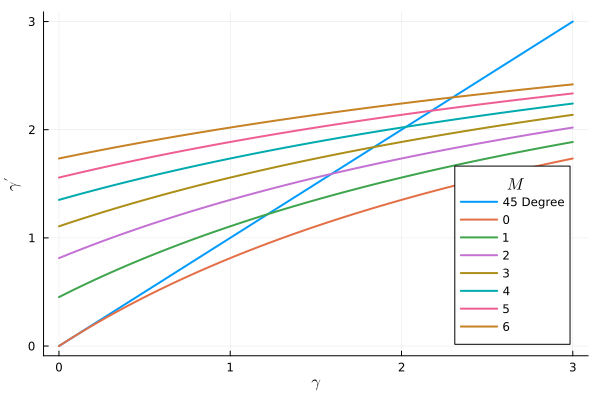

In [4]:
econ = UncertaintyTrapEcon()
@unpack ρ, σ_θ, γ_x = econ # simplify names

# grid for γ and γ_{t+1}
γ = range(1e-10, 3, length = 200)
M_range = 0:6
γp = 1 ./ (ρ^2 ./ (γ .+ γ_x .* M_range') .+ σ_θ^2)

labels = ["0" "1" "2" "3" "4" "5" "6"]

plot(γ, γ, lw = 2, label = "45 Degree")
plot!(γ, γp, lw = 2, label = labels)
plot!(xlabel = L"\gamma", ylabel = L"\gamma^\prime", legend_title = L"M", legend = :bottomright)

In [5]:
@testset begin
    @test γp[2,2] ≈ 0.46450522950184053
    @test γp[3,3] ≈ 0.8323524432613787
    @test γp[5,5] ≈ 1.3779664509290432
end

Test Summary: | Pass  Total  Time
test set      |    3      3  1.7s


Test.DefaultTestSet("test set", Any[], 3, false, false, true, 1.690420720020178e9, 1.69042072169824e9, false)

The points where the curves hit the 45 degree lines are the long run
steady states corresponding to each $M$, if that value of
$M$ was to remain fixed. As the number of firms falls, so does the
long run steady state of precision.

Next let's generate time series for beliefs and the aggregates -- that
is, the number of active firms and average output

In [6]:
function simulate(uc, capT = 2_000)
    # unpack parameters
    @unpack a, γ_x, ρ, σ_θ, num_firms, σ_F, c, μ_init, γ_init, θ_init, σ_x = uc

    # draw standard normal shocks
    w_shocks = randn(capT)

    # aggregate functions
    # auxiliary function ψ
    function ψ(γ, μ, F)
        temp1 = -a * (μ - F)
        temp2 = 0.5 * a^2 / (γ + γ_x)
        return (1 - exp(temp1 + temp2)) / a - c
    end

    # compute X, M
    function gen_aggregates(γ, μ, θ)
        F_vals = σ_F * randn(num_firms)
        M = sum(ψ.(Ref(γ), Ref(μ), F_vals) .> 0) # counts number of active firms
        if any(ψ(γ, μ, f) > 0 for f in F_vals) # ∃ an active firm
            x_vals = θ .+ σ_x * randn(M)
            X = mean(x_vals)
        else
            X = 0.0
        end
        return (X = X, M = M)
    end

    # initialize dataframe
    X_init, M_init = gen_aggregates(γ_init, μ_init, θ_init)
    df = DataFrame(γ = γ_init, μ = μ_init, θ = θ_init, X = X_init, M = M_init)

    # update dataframe
    for t in 2:capT
        # unpack old variables
        θ_old, γ_old, μ_old, X_old, M_old = (df.θ[end], df.γ[end], df.μ[end], df.X[end], df.M[end])

        # define new beliefs
        θ = ρ * θ_old + σ_θ * w_shocks[t-1]
        μ = (ρ * (γ_old * μ_old + M_old * γ_x * X_old))/(γ_old + M_old * γ_x)
        γ = 1 / (ρ^2 / (γ_old + M_old * γ_x) + σ_θ^2)

        # compute new aggregates
        X, M = gen_aggregates(γ, μ, θ)
        push!(df, (γ = γ, μ = μ, θ = θ, X = X, M = M))
    end

    # return
    return df
end

simulate (generic function with 2 methods)

First let's see how well $\mu$ tracks $\theta$ in these
simulations

In [7]:
Random.seed!(42);  # set random seed for reproducible results

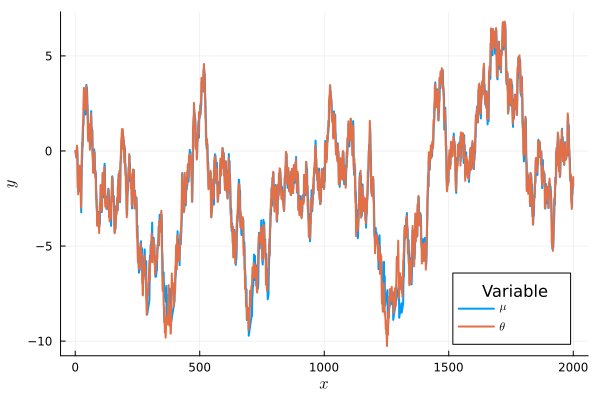

In [8]:
df = simulate(econ)

plot(eachindex(df.μ), df.μ, lw = 2, label = L"\mu")
plot!(eachindex(df.θ), df.θ, lw = 2, label = L"\theta")
plot!(xlabel = L"x", ylabel = L"y", legend_title = "Variable", legend = :bottomright)

Now let's plot the whole thing together

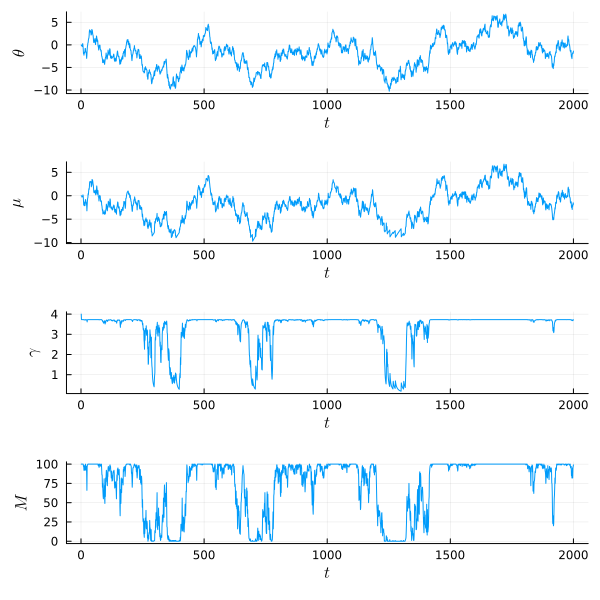

In [9]:
len = eachindex(df.θ)
yvals = [df.θ, df.μ, df.γ, df.M]
vars = [L"\theta", L"\mu", L"\gamma", L"M"]

plt = plot(layout = (4,1), size = (600, 600))

for i in 1:4
    plot!(plt[i], len, yvals[i], xlabel = L"t", ylabel = vars[i], label = "")
end

plot(plt)

<!-- 
```{code-cell} julia
---
tags: [remove-cell]
---
mdf = DataFrame(t = eachindex(df.θ), θ = df.θ, μ = df.μ, γ = df.γ, M = df.M)

@testset begin
    @test stack(mdf, collect(2:5))[:value][3] ≈ -0.49742498224730913 atol = 1e-3
    @test stack(mdf, collect(2:5))[:value][30] ≈ -3.674770452701049 atol = 1e-3
end
``` -->